#### Download Amazon E-Com Data

In [1]:
!wget https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar
#!wget https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-original.tar
#https://amazon-berkeley-objects.s3.amazonaws.com/index.html

--2024-11-08 03:11:39--  https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar
Resolving amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)... 16.15.178.117, 52.217.206.105, 3.5.27.237, ...
Connecting to amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)|16.15.178.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3253381120 (3.0G) [application/x-tar]
Saving to: ‘abo-images-small.tar’

abo-images-small.ta 100%[===================>]   3.03G  18.8MB/s    in 2m 41s  

2024-11-08 03:14:20 (19.3 MB/s) - ‘abo-images-small.tar’ saved [3253381120/3253381120]



In [2]:
!wget https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar

--2024-11-08 03:14:20--  https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar
Resolving amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)... 52.217.69.124, 54.231.232.233, 16.182.67.81, ...
Connecting to amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)|52.217.69.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87480320 (83M) [application/x-tar]
Saving to: ‘abo-listings.tar’

abo-listings.tar    100%[===================>]  83.43M  15.8MB/s    in 5.3s    

2024-11-08 03:14:26 (15.8 MB/s) - ‘abo-listings.tar’ saved [87480320/87480320]



#### Extract Data

In [10]:
import os
import gzip
import json
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import warnings
warnings.filterwarnings('ignore')

In [5]:
shutil.unpack_archive("/content/abo-images-small.tar", "/content/abo-images-small")

shutil.unpack_archive("/content/abo-listings.tar", "/content/abo-listings")

In [6]:
ls /content/abo-listings/listings/metadata/

listings_0.json.gz  listings_4.json.gz  listings_8.json.gz  listings_c.json.gz
listings_1.json.gz  listings_5.json.gz  listings_9.json.gz  listings_d.json.gz
listings_2.json.gz  listings_6.json.gz  listings_a.json.gz  listings_e.json.gz
listings_3.json.gz  listings_7.json.gz  listings_b.json.gz  listings_f.json.gz


In [7]:
# Path to the folder containing .json.gz files
folder_path = '/content/abo-listings/listings/metadata'
data_dict = dict()
# Iterate through all the files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.json.gz'):  # Check if the file is a .json.gz file
        file_path = os.path.join(folder_path, file_name)

        # Open and read the gzipped JSON file line by line
        with gzip.open(file_path, 'rt', encoding='utf-8') as gz_file:
            print(f"Reading file: {file_name}")
            for idx , line in enumerate(gz_file):  # Read each line
                try:
                    data = json.loads(line)  # Load each line as a separate JSON object
                    for item_name in data['item_name'] :
                      if('en_' in item_name['language_tag']) :
                        data_dict[f"{file_name}_{idx}"] = dict()
                        data_dict[f"{file_name}_{idx}"]["product_name"] = item_name['value']
                        data_dict[f"{file_name}_{idx}"]["hierarchy"] = data.get('node',None)
                        all_image_id = [data.get('main_image_id',None)]
                        if data.get('other_image_id',None) :
                          pass
                          # all_image_id.extend(data.get('other_image_id',None))
                        data_dict[f"{file_name}_{idx}"]["image_id"] = all_image_id
                except json.JSONDecodeError as e:
                    print(f"Could not parse JSON in file {file_name}: {e}")

Reading file: listings_1.json.gz
Reading file: listings_4.json.gz
Reading file: listings_2.json.gz
Reading file: listings_a.json.gz
Reading file: listings_d.json.gz
Reading file: listings_0.json.gz
Reading file: listings_8.json.gz
Reading file: listings_f.json.gz
Reading file: listings_3.json.gz
Reading file: listings_7.json.gz
Reading file: listings_6.json.gz
Reading file: listings_b.json.gz
Reading file: listings_c.json.gz
Reading file: listings_9.json.gz
Reading file: listings_e.json.gz
Reading file: listings_5.json.gz


#### Data Cleaing

In [11]:
all_data = []
for key in data_dict.keys() :
  d = data_dict[key]
  d['key'] = key
  all_data.append(d)

ecomm_data = pd.DataFrame((all_data))
ecomm_data = ecomm_data.explode('image_id')
ecomm_data = ecomm_data.dropna()
ecomm_data.drop(columns = ['key'],inplace = True)
ecomm_data["clean_hierarchy"] = ecomm_data.hierarchy.apply(lambda x : x[-1]['node_name'])
ecomm_data = ecomm_data.dropna()
ecomm_data = ecomm_data[ecomm_data.clean_hierarchy.str.find('カテゴリー別') == -1]
ecomm_data["target_class"] = ecomm_data.clean_hierarchy.apply(lambda text :  text.split("/")[-2])
ecomm_data = ecomm_data[ecomm_data['target_class'] != ""]

ecomm_data_agg = ecomm_data.groupby('target_class').agg({'target_class':'count'}).rename(columns = {'target_class':'count'}).reset_index()
target_class_list = ecomm_data_agg[ecomm_data_agg['count'] > 222].target_class.unique()

ecomm_data = ecomm_data[ecomm_data.target_class.isin(target_class_list)]

ecomm_data_rest = ecomm_data[ecomm_data.target_class != 'Cases & Covers']
ecomm_data_cc = ecomm_data[ecomm_data.target_class == 'Cases & Covers']

ecomm_data = pd.concat([ecomm_data_rest,ecomm_data_cc.sample(3000)]).reset_index(drop =True)

In [12]:
image_metadata = pd.read_csv("/content/abo-images-small/images/metadata/images.csv.gz")
ecomm_data_final = pd.merge(ecomm_data,image_metadata[['image_id','path']],on = 'image_id',how = 'inner')

#### EDA

In [15]:
from random import randint

In [16]:
ecomm_data_final.shape, ecomm_data_final.target_class.nunique()

((25037, 6), 34)

In [17]:
ecomm_data_final.head()

,product_name,hierarchy,image_id,clean_hierarchy,target_class,path
0,"find. Men's 17036EV1336, Black), Medium (Size:M)","[{'node_id': 8794286011, 'node_name': '/Catego...",618N+3cU3aL,/Categories/Men/Accessories/Belts,Accessories,ba/ba078df4.jpg
1,Fusefit Men's Sapphire Navy Running Shoes-6 UK...,"[{'node_id': 1983550031, 'node_name': '/Catego...",81IwcS1eysL,/Categories/Shoes/Men's Shoes/Sports & Outdoor...,Sports & Outdoor Shoes,11/113cce67.jpg
2,"Amazon Meal Kits, Hawaiian BBQ Glazed Pork, Se...","[{'node_id': 15709227011, 'node_name': '/Categ...",71c7fe+sWXL,/Categories/Fresh Meal Kits,Categories,84/84dae668.jpg
3,Fusefit Men's Bambino Navy Running Shoes-8 UK ...,"[{'node_id': 1983550031, 'node_name': '/Catego...",71g5tGp2MbL,/Categories/Shoes/Men's Shoes/Sports & Outdoor...,Sports & Outdoor Shoes,25/25548d6d.jpg
4,Flavia Women's Tan Fashion Slippers-8 UK (40 E...,"[{'node_id': 1983639031, 'node_name': '/Catego...",71HlczOsStL,/Categories/Shoes/Women's Shoes/Fashion Slippers,Women's Shoes,dd/dd665fe1.jpg


In [18]:
ecomm_data_final.target_class.value_counts()

,count
target_class,
Cases & Covers,3000
Shoes,2878
Living Room Furniture,1949
Casual Shoes,1808
Men's Shoes,1753
Women,1364
Categories,946
Mobile Accessories,912
Sports & Outdoor Shoes,885


In [19]:
ecomm_data_final.isnull().sum()

,0
product_name,0
hierarchy,0
image_id,0
clean_hierarchy,0
target_class,0
path,0


Sample Data point : 


{'product_name': "Amazon Brand - Symbol Men's Tan PU Formal Shoes - 9 UK (AZ-SY-424)",
 'hierarchy': [{'node_id': 1983572031,
   'node_name': "/Categories/Shoes/Men's Shoes/Formal Shoes"}],
 'image_id': '71uJU0T643L',
 'clean_hierarchy': "/Categories/Shoes/Men's Shoes/Formal Shoes",
 'target_class': "Men's Shoes",
 'path': 'db/db7dd250.jpg'}

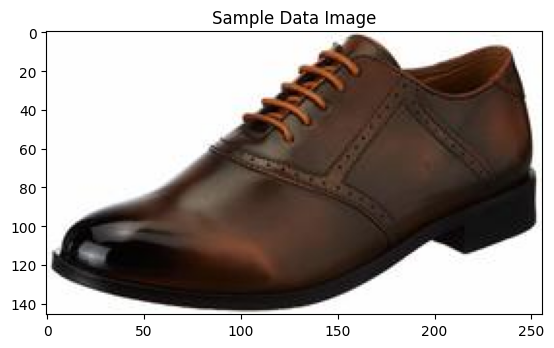

In [23]:
sample_data = ecomm_data_final.to_dict(orient = 'records')[randint(0,len(ecomm_data_final))]
img = plt.imread(f"/content/abo-images-small/images/small/{sample_data['path']}")
plt.title(f"{sample_data['product_name'],sample_data['hierarchy'][-1]['node_name']}")
plt.title("Sample Data Image")
plt.imshow(img)
print("Sample Data point : ")
sample_data

#### Train Test Split

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

strat_column = 'target_class'
train_size = 0.7
val_size = 0.15
test_size = 0.15

label_encoder = LabelEncoder()
ecomm_data_final['label'] = label_encoder.fit_transform(ecomm_data_final[strat_column])

train_data, temp_data = train_test_split(ecomm_data_final,
                                         stratify=ecomm_data_final[strat_column],
                                         test_size=(val_size + test_size),
                                         random_state=42)

val_data, test_data = train_test_split(temp_data,
                                       stratify=temp_data[strat_column],
                                       test_size=test_size/(test_size + val_size),
                                       random_state=42)

train_data['split'] = 'train'
val_data['split'] = 'validation'
test_data['split'] = 'test'

ecomm_data_final = pd.concat([train_data, val_data, test_data])

print(ecomm_data_final['split'].value_counts())


split
train         17525
validation     3756
test           3756
Name: count, dtype: int64


In [25]:
ecomm_data_final.to_csv("data.csv",index = False)

In [26]:
ecomm_data_final.label.min(),ecomm_data_final.label.max(), ecomm_data_final.target_class.nunique()

(0, 33, 34)

#### Torch Dataset

In [54]:
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor
from dataclasses import dataclass

In [55]:
class EcommerceDataset(Dataset):
    def __init__(self, root_folder = "/content", image_folder = "/content/abo-images-small/images/small/", split='train',image_size=224):
        super(EcommerceDataset, self).__init__()
        self.root_folder = root_folder
        self.image_folder = image_folder
        self.split = split
        self.image_size = image_size
        self.info_file = os.path.join(root_folder, 'data.csv')
        self.df = pd.read_csv(self.info_file)
        self.df = self.df[self.df['split']==self.split].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        item = {}
        image_path = row['path']
        item['image'] = Image.open(f"{self.image_folder}/{image_path}").convert('RGB').resize((self.image_size, self.image_size))
        item['text'] = row['product_name']
        item['labels'] = row['label']

        return item

In [56]:
@dataclass
class Arguments:
    blip_pretrained_model = 'Salesforce/blip-image-captioning-base'  # BLIP model name
    image_size = 224
    batch_size = 32
    num_cpus = os.cpu_count()
    use_pretrained_map = False
    num_mapping_layers = 1
    map_dim = 256
    fusion = 'cross'
    num_pre_output_layers = 3
    lr = 0.001
    weight_decay = 1e-3
    weight_image_loss = 0
    weight_text_loss = 0
    weight_super_loss = 0
    drop_probs = [0.1, 0.1, 0.1]
    freeze_image_encoder = True
    freeze_text_encoder = True
    num_class = 34

args = Arguments()

In [57]:
def load_dataset(args, split):
    image_folder = "/content/abo-images-small/images/small/"
    dataset = EcommerceDataset(root_folder='/content', image_folder=image_folder, split=split, image_size=args.image_size)
    return dataset

In [58]:
dataset_train = load_dataset(args, split='train')
dataset_validation = load_dataset(args, split='validation')
dataset_test = load_dataset(args, split='test')

In [59]:
len(dataset_train),len(dataset_validation),len(dataset_test)

(17525, 3756, 3756)

In [60]:
class CustomCollator(object):
    def __init__(self, args):
        self.args = args
        # Load the BLIP processor for image and text processing
        self.processor = BlipProcessor.from_pretrained(args.blip_pretrained_model)

    def __call__(self, batch):
        # Extract images and text data from the batch
        images = [item['image'] for item in batch]
        texts = [item['text'] for item in batch]

        # Process images and text using BLIP processor
        processed_inputs = self.processor(images=images, text=texts, return_tensors="pt", padding=True, truncation=True)

        # Extract necessary tensors
        pixel_values = processed_inputs['pixel_values']  # Shape: [batch_size, 3, 224, 224]
        input_ids = processed_inputs['input_ids']
        attention_mask = processed_inputs['attention_mask']

        # Collect labels
        labels = torch.LongTensor([item['labels'] for item in batch])

        # Build the final batch dictionary
        batch_new = {
            'pixel_values': (pixel_values,),
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

        return batch_new

In [61]:
collator = CustomCollator(args)

train_dataloader = DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True,
                              num_workers=args.num_cpus, collate_fn=collator)

val_dataloader = DataLoader(dataset_validation, batch_size=args.batch_size, shuffle=False,
                            num_workers=args.num_cpus, collate_fn=collator)

test_dataloader = DataLoader(dataset_test, batch_size=args.batch_size, shuffle=False,
                             num_workers=args.num_cpus, collate_fn=collator)


In [70]:
for x in test_dataloader :
  break

x['pixel_values'][0].shape

torch.Size([32, 3, 384, 384])

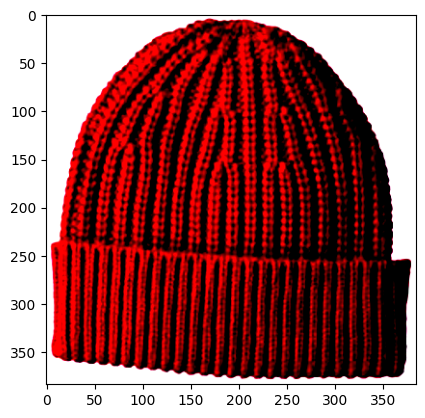

In [71]:
plt.imshow(x['pixel_values'][0][1].permute(1,2,0).numpy())
# plt.title("Sample image for dataloader")

#### Model Architecture

In [72]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 14.4 MB/s eta 0:00:00


In [73]:
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from pyexpat import features
import copy
import math
from sys import prefix
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from transformers import BlipModel, AutoConfig, AutoModel
import torchmetrics

In [74]:
class BLIPClassifier(nn.Module):

    def __init__(self, args):
        super().__init__()

        self.num_mapping_layers = args.num_mapping_layers
        self.map_dim = args.map_dim
        self.fusion = args.fusion
        self.num_pre_output_layers = args.num_pre_output_layers
        self.lr = args.lr
        self.weight_decay = args.weight_decay
        self.weight_image_loss = args.weight_image_loss
        self.weight_text_loss = args.weight_text_loss

        # Load the BLIP model
        self.blip = BlipModel.from_pretrained(args.blip_pretrained_model)

        # Encoder Layers
        self.image_encoder = copy.deepcopy(self.blip.vision_model)
        self.text_encoder = copy.deepcopy(self.blip.text_model)

        ## Projection Layers
        image_map_layers = [nn.Linear(self.image_encoder.config.hidden_size, self.map_dim), nn.Dropout(p=args.drop_probs[0])]
        text_map_layers = [nn.Linear(self.text_encoder.config.hidden_size, self.map_dim), nn.Dropout(p=args.drop_probs[0])]
        for _ in range(1, self.num_mapping_layers):
            image_map_layers.extend([nn.ReLU(), nn.Linear(self.map_dim, self.map_dim), nn.Dropout(p=args.drop_probs[0])])
            text_map_layers.extend([nn.ReLU(), nn.Linear(self.map_dim, self.map_dim), nn.Dropout(p=args.drop_probs[0])])

        self.image_map = nn.Sequential(*image_map_layers)
        self.text_map = nn.Sequential(*text_map_layers)

        ## Pre Output Layers
        if args.fusion in ['align', 'align_shuffle']:
            pre_output_input_dim = self.map_dim
        elif args.fusion == 'concat':
            pre_output_input_dim = self.map_dim*2
        elif args.fusion.startswith('cross'):
            pre_output_input_dim = self.map_dim**2
        elif args.fusion == 'align_concat':
            pre_output_input_dim = self.map_dim*3
        elif args.fusion == 'attention_m':
            self.gen_query = nn.Linear(self.map_dim, self.map_dim//4)
            self.gen_key = nn.Linear(self.map_dim, self.map_dim//4)
            self.soft = nn.Softmax(dim=1)
            pre_output_input_dim = self.map_dim*2

        pre_output_layers = [nn.Dropout(p=args.drop_probs[1])]
        output_input_dim = pre_output_input_dim
        if self.num_pre_output_layers >= 1: # first pre-output layer
            pre_output_layers.extend([nn.Linear(pre_output_input_dim, self.map_dim), nn.ReLU(), nn.Dropout(p=args.drop_probs[2])])
            output_input_dim = self.map_dim
        for _ in range(1, self.num_pre_output_layers): # next pre-output layers
            pre_output_layers.extend([nn.Linear(self.map_dim, self.map_dim), nn.ReLU(), nn.Dropout(p=args.drop_probs[2])])

        self.pre_output = nn.Sequential(*pre_output_layers)

        ## Output Layer
        self.output = nn.Linear(output_input_dim, args.num_class)

        if args.freeze_image_encoder:
            for _, p in self.image_encoder.named_parameters():
                p.requires_grad_(False)

        if args.freeze_text_encoder:
            for _, p in self.text_encoder.named_parameters():
                p.requires_grad_(False)

        del self.blip

    def forward(self, batch):
        image_features = self.image_encoder(pixel_values=batch['pixel_values'][0]).pooler_output
        image_features = self.image_map(image_features)

        text_features = self.text_encoder(input_ids=batch['input_ids'], attention_mask=batch['attention_mask']).pooler_output
        text_features = self.text_map(text_features)

        image_features = F.normalize(image_features, p=2, dim=1) # [batch_size, d]
        text_features = F.normalize(text_features, p=2, dim=1) # [batch_size, d]

        if self.fusion in ['align', 'align_shuffle']:
            features = torch.mul(image_features, text_features)  # [batch_size, d]

        elif self.fusion == 'concat':
            features = torch.cat([image_features, text_features], dim=1)  # [batch_size, 2*d]

        elif self.fusion.startswith('cross'):
            features = torch.bmm(image_features.unsqueeze(2), text_features.unsqueeze(1)) # [batch_size, d, d]
            if self.fusion == 'cross_nd':
                mask = torch.eye(self.map_dim).repeat(features.shape[0], 1, 1).bool()
                features[mask] = torch.zeros(features.shape[0]*self.map_dim, device=features.device)
                del mask
            features = features.reshape(features.shape[0], -1)  # [batch_size, d*d]

        elif self.fusion == 'align_concat':
            features = torch.cat([torch.mul(image_features, text_features), image_features, text_features], dim=1)  # [batch_size, 3*d]

        elif self.fusion == 'attention_m':
            q1 = F.relu(self.gen_query(image_features))
            k1 = F.relu(self.gen_key(image_features))
            q2 = F.relu(self.gen_query(text_features))
            k2 = F.relu(self.gen_key(text_features))
            score1 = torch.reshape(torch.bmm(q1.view(-1, 1, 256), k2.view(-1, 256, 1)), (-1, 1))
            score2 = torch.reshape(torch.bmm(q2.view(-1, 1, 256), k1.view(-1, 256, 1)), (-1, 1))
            wt_score1_score2_mat = torch.cat((score1, score2), 1)
            wt_i1_i2 = self.soft(wt_score1_score2_mat.float()) #prob
            prob_1 = wt_i1_i2[:,0]
            prob_2 = wt_i1_i2[:,1]
            wtd_i1 = image_features * prob_1[:, None]
            wtd_i2 = text_features * prob_2[:, None]
            features = torch.cat((wtd_i1,wtd_i2), 1) # [batch_size, 2*d]
        else:
                raise ValueError()

        features = self.pre_output(features)
        logits = self.output(features)

        # probs = F.softmax(logits, dim=1)

        return logits

In [ ]:
model = BLIPClassifier(args)
model

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_mo

BLIPClassifier(
  (image_encoder): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, elementwis

In [ ]:
trainable_layers = [(name, param) for name, param in model.named_parameters() if param.requires_grad]

for name, param in trainable_layers:
    print(f"Layer: {name}, Size: {param.size()}")

Layer: image_map.0.weight, Size: torch.Size([256, 768])
Layer: image_map.0.bias, Size: torch.Size([256])
Layer: text_map.0.weight, Size: torch.Size([256, 768])
Layer: text_map.0.bias, Size: torch.Size([256])
Layer: pre_output.1.weight, Size: torch.Size([256, 65536])
Layer: pre_output.1.bias, Size: torch.Size([256])
Layer: pre_output.4.weight, Size: torch.Size([256, 256])
Layer: pre_output.4.bias, Size: torch.Size([256])
Layer: pre_output.7.weight, Size: torch.Size([256, 256])
Layer: pre_output.7.bias, Size: torch.Size([256])
Layer: output.weight, Size: torch.Size([34, 256])
Layer: output.bias, Size: torch.Size([34])


#### Train and Validation Function

In [ ]:
def train_and_validate(model, train_dataloader, val_dataloader, epochs, device, loss_fn,optimizer, scheduler=None, print_every=100):
    """
    Train and validate the model.

    :param model: The CLIPClassifier model.
    :param train_dataloader: DataLoader for the training dataset.
    :param val_dataloader: DataLoader for the validation dataset.
    :param epochs: Number of training epochs.
    :param device: The device to use for training (e.g., 'cuda' or 'cpu').
    :param loss_fn: Loss function for training.
    :param optimizer: Optimizer for model training.
    :param scheduler: Learning rate scheduler (optional).
    :param print_every: How frequently to print training status.
    """

    model.to(device)

    # Trackers for loss and accuracy
    best_val_accuracy = 0.0

    # Loop over epochs
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        total_train_loss = 0.0
        train_preds = []
        train_labels = []

        # Progress bar for training
        train_progress = tqdm(train_dataloader, desc='Training', leave=False)

        for batch_idx, batch in enumerate(train_progress):
            # Move batch to device
            pixel_values = batch['pixel_values'][0].to(device)
            pixel_values = [pixel_values]
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            # Forward pass
            preds = model({
                'pixel_values': pixel_values,
                'input_ids': input_ids,
                'attention_mask': attention_mask
            })

            # Compute loss
            loss = loss_fn(preds, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

            # Track loss and accuracy
            total_train_loss += loss.item()
            train_preds.extend(torch.argmax(preds,dim=1).detach().cpu().numpy())
            train_labels.extend(labels.detach().cpu().numpy())

            # Print progress
            if batch_idx % print_every == 0:
                avg_loss = total_train_loss / (batch_idx + 1)
                print(f"Batch {batch_idx}, Training Loss: {avg_loss:.4f}")

        # Calculate train accuracy
        train_accuracy = accuracy_score(train_labels, train_preds)
        print(f"Epoch {epoch + 1} Training Loss: {total_train_loss / len(train_dataloader):.4f}")
        print(f"Epoch {epoch + 1} Training Accuracy: {train_accuracy:.4f}")

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            val_progress = tqdm(val_dataloader, desc='Validating', leave=False)

            for batch in val_progress:
                # Move batch to device
                pixel_values = batch['pixel_values'][0].to(device)
                pixel_values = [pixel_values]
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                preds = model({
                    'pixel_values': pixel_values,
                    'input_ids': input_ids,
                    'attention_mask': attention_mask
                })

                # Compute loss
                loss = loss_fn(preds, labels)
                total_val_loss += loss.item()

                # Track predictions and labels
                val_preds.extend(torch.argmax(preds,dim=1).detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())

        # Calculate validation accuracy
        val_accuracy = accuracy_score(val_labels, val_preds)
        print(f"Epoch {epoch + 1} Validation Loss: {total_val_loss / len(val_dataloader):.4f}")
        print(f"Epoch {epoch + 1} Validation Accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Best model saved with validation accuracy: {best_val_accuracy:.4f}")

    print(f"Training complete. Best Validation Accuracy: {best_val_accuracy:.4f}")


#### Sample 2 epochs without scheduler

In [ ]:
# Assuming you have train_dataloader and val_dataloader ready
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BLIPClassifier(args)

args = args
# Define optimizer and optional scheduler
loss_fn = nn.CrossEntropyLoss()

param_dicts = [
            {"params": [p for n, p in model.named_parameters() if p.requires_grad]}
            ]
optimizer = AdamW(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
scheduler = None


# Train the model
train_and_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=2,
    device=device,
    loss_fn = loss_fn,
    optimizer=optimizer,
    scheduler=scheduler
)

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_mo


Epoch 1/2


Training:   0%|          | 1/548 [00:06<55:54,  6.13s/it]

Batch 0, Training Loss: 3.5346


Training:  18%|█▊        | 101/548 [02:02<08:55,  1.20s/it]

Batch 100, Training Loss: 2.2037


Training:  37%|███▋      | 201/548 [04:05<07:11,  1.24s/it]

Batch 200, Training Loss: 1.7740


Training:  55%|█████▍    | 301/548 [06:09<05:08,  1.25s/it]

Batch 300, Training Loss: 1.5608


Training:  73%|███████▎  | 401/548 [08:14<03:04,  1.26s/it]

Batch 400, Training Loss: 1.4012


Training:  91%|█████████▏| 501/548 [10:21<00:59,  1.26s/it]

Batch 500, Training Loss: 1.2819


Epoch 1 Training Loss: 1.2347
Epoch 1 Training Accuracy: 0.5910


Epoch 1 Validation Loss: 0.7560
Epoch 1 Validation Accuracy: 0.7391
Best model saved with validation accuracy: 0.7391

Epoch 2/2


Training:   0%|          | 1/548 [00:03<29:47,  3.27s/it]

Batch 0, Training Loss: 0.7803


Training:  18%|█▊        | 101/548 [02:11<09:33,  1.28s/it]

Batch 100, Training Loss: 0.6723


Training:  37%|███▋      | 201/548 [04:19<07:26,  1.29s/it]

Batch 200, Training Loss: 0.6641


Training:  55%|█████▍    | 301/548 [06:26<05:17,  1.28s/it]

Batch 300, Training Loss: 0.6749


Training:  73%|███████▎  | 401/548 [08:33<03:07,  1.27s/it]

Batch 400, Training Loss: 0.6746


Training:  91%|█████████▏| 501/548 [10:41<00:59,  1.27s/it]

Batch 500, Training Loss: 0.6667


Epoch 2 Training Loss: 0.6628
Epoch 2 Training Accuracy: 0.7554


Epoch 2 Validation Loss: 0.6427
Epoch 2 Validation Accuracy: 0.7777
Best model saved with validation accuracy: 0.7777
Training complete. Best Validation Accuracy: 0.7777


#### Sample 2 epochs with scheduler

In [ ]:
# Assuming you have train_dataloader and val_dataloader ready
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BLIPClassifier(args)

# Define optimizer and optional scheduler
loss_fn = nn.CrossEntropyLoss()

param_dicts = [
            {"params": [p for n, p in model.named_parameters() if p.requires_grad]}
            ]
optimizer = AdamW(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
# scheduler = None

# Train the model
train_and_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=2,
    device=device,
    loss_fn = loss_fn,
    optimizer=optimizer,
    scheduler=scheduler
)


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_mo


Epoch 1/2


Training:   0%|          | 1/548 [00:03<27:46,  3.05s/it]

Batch 0, Training Loss: 3.5361


Training:  18%|█▊        | 101/548 [02:10<09:33,  1.28s/it]

Batch 100, Training Loss: 3.5236


Training:  37%|███▋      | 201/548 [04:17<07:26,  1.29s/it]

Batch 200, Training Loss: 3.5233


Training:  55%|█████▍    | 301/548 [06:25<05:20,  1.30s/it]

Batch 300, Training Loss: 3.5229


Training:  73%|███████▎  | 401/548 [08:33<03:09,  1.29s/it]

Batch 400, Training Loss: 3.5228


Training:  91%|█████████▏| 501/548 [10:40<00:59,  1.27s/it]

Batch 500, Training Loss: 3.5228


Epoch 1 Training Loss: 3.5229
Epoch 1 Training Accuracy: 0.0390


Epoch 1 Validation Loss: 3.5224
Epoch 1 Validation Accuracy: 0.0397
Best model saved with validation accuracy: 0.0397

Epoch 2/2


Training:   0%|          | 1/548 [00:02<22:44,  2.50s/it]

Batch 0, Training Loss: 3.5120


Training:  18%|█▊        | 101/548 [02:09<09:27,  1.27s/it]

Batch 100, Training Loss: 3.5221


Training:  37%|███▋      | 201/548 [04:17<07:21,  1.27s/it]

Batch 200, Training Loss: 3.5229


Training:  55%|█████▍    | 301/548 [06:24<05:13,  1.27s/it]

Batch 300, Training Loss: 3.5229


Training:  73%|███████▎  | 401/548 [08:31<03:04,  1.26s/it]

Batch 400, Training Loss: 3.5230


Training:  91%|█████████▏| 501/548 [10:39<00:59,  1.26s/it]

Batch 500, Training Loss: 3.5229


Epoch 2 Training Loss: 3.5229
Epoch 2 Training Accuracy: 0.0387


Epoch 2 Validation Loss: 3.5224
Epoch 2 Validation Accuracy: 0.0397
Training complete. Best Validation Accuracy: 0.0397


#### 10 epochs training without scheduler

In [ ]:
# Assuming you have train_dataloader and val_dataloader ready
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BLIPClassifier(args)

args = args
# Define optimizer and optional scheduler
loss_fn = nn.CrossEntropyLoss()

param_dicts = [
            {"params": [p for n, p in model.named_parameters() if p.requires_grad]}
            ]
optimizer = AdamW(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
scheduler = None


# Train the model
train_and_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=10,
    device=device,
    loss_fn = loss_fn,
    optimizer=optimizer,
    scheduler=scheduler
)

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_mo


Epoch 1/10


Training:   0%|          | 1/548 [00:02<21:25,  2.35s/it]

Batch 0, Training Loss: 3.5357


Training:  18%|█▊        | 101/548 [02:10<09:30,  1.28s/it]

Batch 100, Training Loss: 2.1815


Training:  37%|███▋      | 201/548 [04:18<07:19,  1.27s/it]

Batch 200, Training Loss: 1.7468


Training:  55%|█████▍    | 301/548 [06:25<05:19,  1.30s/it]

Batch 300, Training Loss: 1.4956


Training:  73%|███████▎  | 401/548 [08:33<03:07,  1.28s/it]

Batch 400, Training Loss: 1.3358


Training:  91%|█████████▏| 501/548 [10:40<01:00,  1.28s/it]

Batch 500, Training Loss: 1.2226


Epoch 1 Training Loss: 1.1743
Epoch 1 Training Accuracy: 0.6068


Epoch 1 Validation Loss: 0.6674
Epoch 1 Validation Accuracy: 0.7484
Best model saved with validation accuracy: 0.7484

Epoch 2/10


Training:   0%|          | 1/548 [00:02<23:29,  2.58s/it]

Batch 0, Training Loss: 0.5409


Training:  18%|█▊        | 101/548 [02:10<09:26,  1.27s/it]

Batch 100, Training Loss: 0.6833


Training:  37%|███▋      | 201/548 [04:17<07:22,  1.27s/it]

Batch 200, Training Loss: 0.6840


Training:  55%|█████▍    | 301/548 [06:25<05:14,  1.27s/it]

Batch 300, Training Loss: 0.6705


Training:  73%|███████▎  | 401/548 [08:32<03:06,  1.27s/it]

Batch 400, Training Loss: 0.6596


Training:  91%|█████████▏| 501/548 [10:40<00:59,  1.27s/it]

Batch 500, Training Loss: 0.6513


Epoch 2 Training Loss: 0.6510
Epoch 2 Training Accuracy: 0.7595


Epoch 2 Validation Loss: 0.6165
Epoch 2 Validation Accuracy: 0.7761
Best model saved with validation accuracy: 0.7761

Epoch 3/10


Training:   0%|          | 1/548 [00:02<22:20,  2.45s/it]

Batch 0, Training Loss: 0.3732


Training:  18%|█▊        | 101/548 [02:10<09:31,  1.28s/it]

Batch 100, Training Loss: 0.5832


Training:  37%|███▋      | 201/548 [04:17<07:19,  1.27s/it]

Batch 200, Training Loss: 0.5758


Training:  55%|█████▍    | 301/548 [06:25<05:16,  1.28s/it]

Batch 300, Training Loss: 0.5762


Training:  73%|███████▎  | 401/548 [08:32<03:08,  1.28s/it]

Batch 400, Training Loss: 0.5678


Training:  91%|█████████▏| 501/548 [10:40<00:59,  1.27s/it]

Batch 500, Training Loss: 0.5675


Epoch 3 Training Loss: 0.5704
Epoch 3 Training Accuracy: 0.7843


Epoch 3 Validation Loss: 0.5929
Epoch 3 Validation Accuracy: 0.7849
Best model saved with validation accuracy: 0.7849

Epoch 4/10


Training:   0%|          | 1/548 [00:02<21:04,  2.31s/it]

Batch 0, Training Loss: 0.3863


Training:  18%|█▊        | 101/548 [02:09<09:30,  1.28s/it]

Batch 100, Training Loss: 0.5246


Training:  37%|███▋      | 201/548 [04:17<07:21,  1.27s/it]

Batch 200, Training Loss: 0.5240


Training:  55%|█████▍    | 301/548 [06:24<05:17,  1.28s/it]

Batch 300, Training Loss: 0.5343


Training:  73%|███████▎  | 401/548 [08:32<03:08,  1.28s/it]

Batch 400, Training Loss: 0.5313


Training:  91%|█████████▏| 501/548 [10:39<00:59,  1.27s/it]

Batch 500, Training Loss: 0.5280


Epoch 4 Training Loss: 0.5266
Epoch 4 Training Accuracy: 0.7963


Epoch 4 Validation Loss: 0.5554
Epoch 4 Validation Accuracy: 0.7982
Best model saved with validation accuracy: 0.7982

Epoch 5/10


Training:   0%|          | 1/548 [00:02<21:54,  2.40s/it]

Batch 0, Training Loss: 0.3703


Training:  18%|█▊        | 101/548 [02:10<09:25,  1.27s/it]

Batch 100, Training Loss: 0.4734


Training:  37%|███▋      | 201/548 [04:18<07:30,  1.30s/it]

Batch 200, Training Loss: 0.4753


Training:  55%|█████▍    | 301/548 [06:25<05:16,  1.28s/it]

Batch 300, Training Loss: 0.4861


Training:  73%|███████▎  | 401/548 [08:33<03:10,  1.29s/it]

Batch 400, Training Loss: 0.4833


Training:  91%|█████████▏| 501/548 [10:40<00:59,  1.27s/it]

Batch 500, Training Loss: 0.4817


Epoch 5 Training Loss: 0.4825
Epoch 5 Training Accuracy: 0.8122


Epoch 5 Validation Loss: 0.5489
Epoch 5 Validation Accuracy: 0.8040
Best model saved with validation accuracy: 0.8040

Epoch 6/10


Training:   0%|          | 1/548 [00:02<21:29,  2.36s/it]

Batch 0, Training Loss: 0.3667


Training:  18%|█▊        | 101/548 [02:10<09:37,  1.29s/it]

Batch 100, Training Loss: 0.4444


Training:  37%|███▋      | 201/548 [04:18<07:23,  1.28s/it]

Batch 200, Training Loss: 0.4569


Training:  55%|█████▍    | 301/548 [06:25<05:18,  1.29s/it]

Batch 300, Training Loss: 0.4613


Training:  73%|███████▎  | 401/548 [08:33<03:07,  1.27s/it]

Batch 400, Training Loss: 0.4628


Training:  91%|█████████▏| 501/548 [10:41<01:00,  1.28s/it]

Batch 500, Training Loss: 0.4538


Epoch 6 Training Loss: 0.4505
Epoch 6 Training Accuracy: 0.8243


Epoch 6 Validation Loss: 0.5680
Epoch 6 Validation Accuracy: 0.8046
Best model saved with validation accuracy: 0.8046

Epoch 7/10


Training:   0%|          | 1/548 [00:02<22:15,  2.44s/it]

Batch 0, Training Loss: 0.3216


Training:  18%|█▊        | 101/548 [02:08<09:24,  1.26s/it]

Batch 100, Training Loss: 0.4331


Training:  37%|███▋      | 201/548 [04:15<07:18,  1.26s/it]

Batch 200, Training Loss: 0.4266


Training:  55%|█████▍    | 301/548 [06:21<05:15,  1.28s/it]

Batch 300, Training Loss: 0.4352


Training:  73%|███████▎  | 401/548 [08:28<03:06,  1.27s/it]

Batch 400, Training Loss: 0.4306


Training:  91%|█████████▏| 501/548 [10:35<00:59,  1.28s/it]

Batch 500, Training Loss: 0.4298


Epoch 7 Training Loss: 0.4296
Epoch 7 Training Accuracy: 0.8293


Epoch 7 Validation Loss: 0.4993
Epoch 7 Validation Accuracy: 0.8216
Best model saved with validation accuracy: 0.8216

Epoch 8/10


Training:   0%|          | 1/548 [00:02<22:36,  2.48s/it]

Batch 0, Training Loss: 0.3608


Training:  18%|█▊        | 101/548 [02:07<09:24,  1.26s/it]

Batch 100, Training Loss: 0.3923


Training:  37%|███▋      | 201/548 [04:13<07:23,  1.28s/it]

Batch 200, Training Loss: 0.3937


Training:  55%|█████▍    | 301/548 [06:20<05:11,  1.26s/it]

Batch 300, Training Loss: 0.3899


Training:  73%|███████▎  | 401/548 [08:27<03:05,  1.26s/it]

Batch 400, Training Loss: 0.4026


Training:  91%|█████████▏| 501/548 [10:34<00:59,  1.27s/it]

Batch 500, Training Loss: 0.4036


Epoch 8 Training Loss: 0.4043
Epoch 8 Training Accuracy: 0.8417


Epoch 8 Validation Loss: 0.5124
Epoch 8 Validation Accuracy: 0.8211

Epoch 9/10


Training:   0%|          | 1/548 [00:02<26:14,  2.88s/it]

Batch 0, Training Loss: 0.1976


Training:  18%|█▊        | 101/548 [02:10<09:26,  1.27s/it]

Batch 100, Training Loss: 0.3792


Training:  37%|███▋      | 201/548 [04:17<07:20,  1.27s/it]

Batch 200, Training Loss: 0.3818


Training:  55%|█████▍    | 301/548 [06:25<05:13,  1.27s/it]

Batch 300, Training Loss: 0.3868


Training:  73%|███████▎  | 401/548 [08:32<03:06,  1.27s/it]

Batch 400, Training Loss: 0.3877


Training:  91%|█████████▏| 501/548 [10:40<00:59,  1.27s/it]

Batch 500, Training Loss: 0.3862


Epoch 9 Training Loss: 0.3857
Epoch 9 Training Accuracy: 0.8488


Epoch 9 Validation Loss: 0.5459
Epoch 9 Validation Accuracy: 0.8206

Epoch 10/10


Training:   0%|          | 1/548 [00:02<20:47,  2.28s/it]

Batch 0, Training Loss: 0.3100


Training:  18%|█▊        | 101/548 [02:09<09:28,  1.27s/it]

Batch 100, Training Loss: 0.3470


Training:  37%|███▋      | 201/548 [04:16<07:17,  1.26s/it]

Batch 200, Training Loss: 0.3601


Training:  55%|█████▍    | 301/548 [06:23<05:15,  1.28s/it]

Batch 300, Training Loss: 0.3690


Training:  73%|███████▎  | 401/548 [08:31<03:07,  1.28s/it]

Batch 400, Training Loss: 0.3660


Training:  91%|█████████▏| 501/548 [10:38<01:00,  1.28s/it]

Batch 500, Training Loss: 0.3704


Epoch 10 Training Loss: 0.3731
Epoch 10 Training Accuracy: 0.8541


Epoch 10 Validation Loss: 0.5559
Epoch 10 Validation Accuracy: 0.8195
Training complete. Best Validation Accuracy: 0.8216


#### Inference on test set with best model

In [ ]:
import torch
import numpy as np

# Define batch size and dimensions
batch_size = 4
image_size = (3, 224, 224)  # Typical image size for models like CLIP (3 channels, 224x224 pixels)
text_sequence_length = 77  # CLIP typically uses a sequence length of 77

# Random input for images (simulating pixel values)
random_images = torch.rand(batch_size, *image_size)  # [batch_size, channels, height, width]

# Random input for text (simulating token ids and attention mask)
random_input_ids = torch.randint(0, 10000, (batch_size, text_sequence_length))  # Random token IDs
random_attention_mask = torch.ones(batch_size, text_sequence_length)  # Attention mask (all ones for simplicity)

# Create the batch input to match the model's expected input format
batch = {
    'pixel_values': [random_images],  # Model expects pixel_values as a list
    'input_ids': random_input_ids,
    'attention_mask': random_attention_mask
}

# Pass this batch into the model's forward method
result = model(batch)


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor